In [1]:
## Goal of this experiment:
## - study samplers in isolation -- away from BNN/Hyperparameter optimization
## - diagnostics of interest: autocorrelation, ESS
## - Samplers to compare to: 
## - SGLD (tensorflow), 
## - SGHMC (theano/keras), 
## - NUTS (pymc3),
## - SVGD (ours/theirs?)
## - relativistic sghmc
## - standard hmc
## - l2hmc (tensorflow/l2hmc)
## - 
## XXX: for a single chain: also show recomputed density approximation of each energy function
## using SGHMC-HD (density/kdeplot from mcmc_visualizer) => and use that to also get videos later for 
## our presentation.
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import sys
from os.path import dirname, expanduser, join as path_join, isdir
from glob import glob
import json
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from collections import defaultdict, OrderedDict

sys.path.insert(0, path_join("..", "..", ".."))
sys.path.insert(0, path_join("..", "..", "..", "pysgmcmc_experiments", "MCMCVisualizer"))

from pysgmcmc_experiments import plot_utils
# XXX: Fix reference to mcmc visualizer (add as submodule?)
from mcmc_visualizer.diagnostics import autocorrelation
from mcmc_visualizer.mcmc_trace import MCMCTrace

RESULT_DIR = path_join(
    "..", "..", "..", 
    "cluster_results", "energy_functions_old"
)


def load_results(directory):
    directories = sorted([
        directory for directory in glob("{}/*".format(directory))
        if isdir(directory)
    ])

    def load_json(filename):
        with open(filename) as f:
            return json.load(f)
    
    chains = defaultdict(lambda: defaultdict(list))
    
    for directory in tqdm(directories, total=len(directories)):
        if "_sources" in directory or "processed_results" in directory:
            continue
            
        result = load_json(path_join(directory, "run.json"))
        
        if result["status"] != "COMPLETED":
            continue
        
        configuration = load_json(path_join(directory, "config.json"))
        energy_function = configuration["energy_function"]
        sampler = configuration["sampler"]
        stepsize = configuration["stepsize"]    
        chains[energy_function][(sampler, stepsize)].append(result["result"]["samples"])
    return chains

chains_dict = load_results(RESULT_DIR)


        

100%|██████████| 3006/3006 [09:25<00:00,  5.31it/s]


In [2]:
from pymc3 import effective_n
import sys

# XXX: Add MCMCVisualizer path to system path

from pysgmcmc_experiments.utils import rename, format_sampler
import numpy as np


def effective_sample_size(energy_functions, aggregate=np.mean):
    
    from collections import defaultdict
    
    records = defaultdict(dict)
    
    for energy_function in energy_functions:
        chains_on_energy = chains_dict[energy_function]

        for (sampler, stepsize), sampler_chains in chains_on_energy.items():
            chains_ = np.asarray(sampler_chains)
            if len(chains_.shape) == 2:
                chains_ = np.expand_dims(chains_, 2)
                
            print(chains_.shape)
            trace = MCMCTrace(sampler_chains)
            multitrace = trace.to_multitrace()

            num_iterations = float(trace.num_chains * trace.num_steps)
            print(trace.num_chains, trace.num_steps)

            ess_per_iteration = (
                aggregate(list(effective_n(multitrace).values())) / num_iterations
            )

            records[rename(energy_function)][format_sampler(sampler=sampler, stepsize=stepsize)] = ess_per_iteration

    
    df = pd.DataFrame.from_records(records)
    df2 = df.astype(float)
    winners_index = df2.idxmax(axis=0)
    for function, method in winners_index.items():
        winning_value = df2[function][method]
        df[function][method] = "\mathbf{{{}}}".format(winning_value)

    df = df.applymap(lambda x: "${}$".format(x))
    df = df.rename(columns={column: "\rotatebox{{45}}{{{name}}}".format(name=column) for column in df.columns.values})
    return df
        
def autocorrelation_diagnostic(energy_function):
    chains_on_energy = chains_dict[energy_function]
    
    timesteps = []
    diagnostics = []
    parameters = []
    chain_ids = []
    samplers = []    
    
    
    
    for (sampler, stepsize), sampler_chains in chains_on_energy.items():
        for chain_id, chain in enumerate(sampler_chains):
            parameter_names = None  # XXX Read that from the chain
            
            diagnostic_dict = autocorrelation(
                MCMCTrace(chain, parameter_names=parameter_names)
            )
            
            for parameter in diagnostic_dict:
                for time, diagnostic_value in enumerate(diagnostic_dict[parameter]):
                    timesteps.append(time)
                    diagnostics.append(diagnostic_value)
                    chain_ids.append(chain_id)
                    parameters.append(parameter)
                    samplers.append((sampler, stepsize))

    return pd.DataFrame(
        data = {
            "Time": timesteps, 
            "Diagnostic": diagnostics,
            "Parameter Name": parameters, 
            "Chain Number": chain_ids,
            "Method": samplers
        }
    )


ENERGY_FUNCTIONS = sorted(chains_dict.keys())


DATA = defaultdict(dict)
from itertools import product

for energy_function in tqdm(ENERGY_FUNCTIONS, total=len(ENERGY_FUNCTIONS)):
    DATA[energy_function]["Autocorrelation"] = autocorrelation_diagnostic(energy_function)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
  0%|          | 0/8 [00:00<?, ?it/s]WARNING:root:No parameter names specified for the given `chains`. Using anonymous names by enumerating all dimensions.


 12%|█▎        | 1/8 [00:31<03:42, 31.83s/it]WARNING:root:No parameter names specified for the given `chains`. Using anonymous names by enumerating all dimensions.


 25%|██▌       | 2/8 [01:03<03:10, 31.83s/it]WARNING:root:No parameter names specified for the given `chains`. Using anonymous names by enumerating all dimensions.


 38%|███▊      | 3/8 [01:20<02:13, 26.69s/it]WARNING:root:No parameter names specified for the given `chains`. Using anonymous names by enumerating all dimensions.


 50%|█████     | 4/8 [01:36<01:36, 24.12s/it]WARNING:root:No parameter names specified for the given `chains`. Using anonymous names by enumerating all dimensions.


 62%|██████▎   | 5/8 [01:53<01:07, 22.66s/it]WARNING:root:No parameter names specified for the given `chains`. Using anonymous names by enumerating all dimensions.


 75%|███████▌  | 6/8 [02:09<00:43, 21.53s/it]WARNING:root:No parameter names specified for the given `chains`. Using anonymous names by enumerating all dimensions.


 88%|████████▊ | 7/8 [02:41<00:23, 23.01s/it]WARNING:root:No parameter names specified for the given `chains`. Using anonymous names by enumerating all dimensions.


100%|██████████| 8/8 [03:03<00:00, 22.96s/it]


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_data(diagnostic_name, energy_function, title=None):
    
    dataframe = DATA[energy_function][diagnostic_name]
    for parameter_name in sorted(set(dataframe["Parameter Name"])):
        ax = sns.tsplot(
            time="Time",
            value="Diagnostic",
            unit="Chain Number",
            condition="Method",
            data=dataframe[dataframe["Parameter Name"] == parameter_name][
                dataframe["Method"] != ("SGLD", 1.0)
            ]
        )
    if title is not None:
        ax.set_title(title)


In [4]:
## write data to csv files.

energy_functions = ("gmm1", "gmm2", "gmm3", "mogl2hmc",
                    "banana", "donut", "squiggle", 
                    "standard_normal",)


AUTOCORRELATION_DIR = path_join(RESULT_DIR,  
                                "processed_results",
                                "autocorrelation")

WRITE_DIR = path_join("/home/moritz/", "test_results")
for energy_function in tqdm(energy_functions, total=len(energy_functions)):
    DATA[energy_function]["Autocorrelation"].to_hdf(
        path_join(WRITE_DIR, "autocorrelation.hdf"),
        key=energy_function,
        mode="a",
        chunksize=4,
        complib="blosc",
        complevel=3,
    )


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['Method', 'Parameter Name']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)
100%|██████████| 8/8 [00:19<00:00,  2.46s/it]


## Plots

We plot autocorrelation as a function of time for each dimension of our energy functions. 


/home/moritz/test_results/autocorrelation.hdf


/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


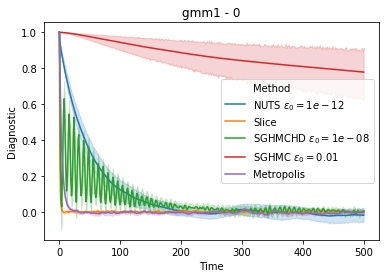

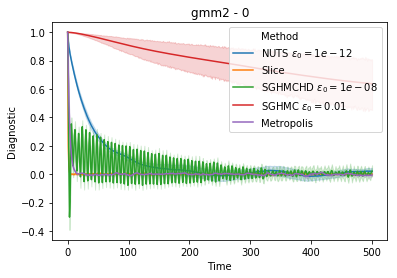

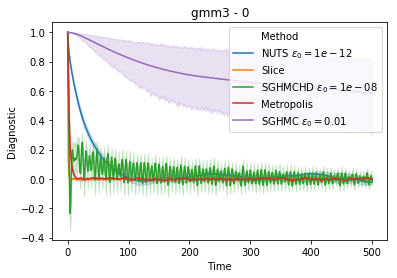

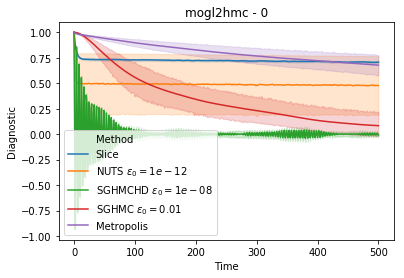

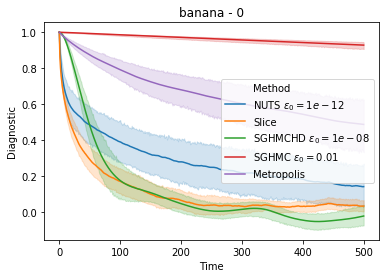

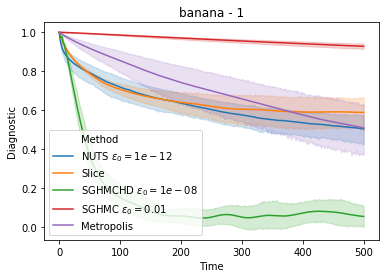

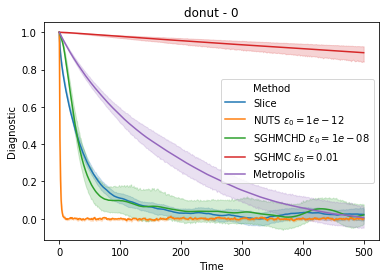

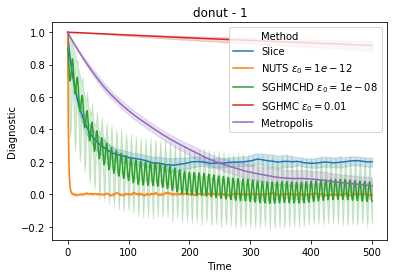

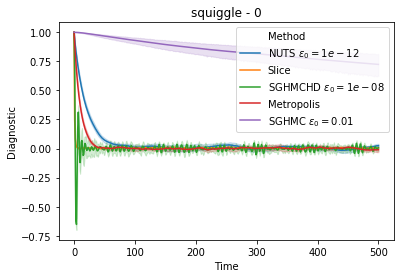

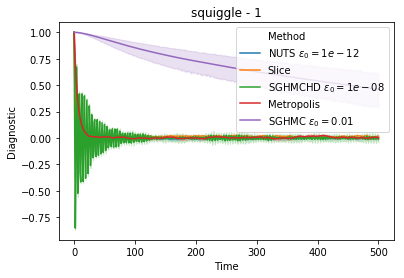

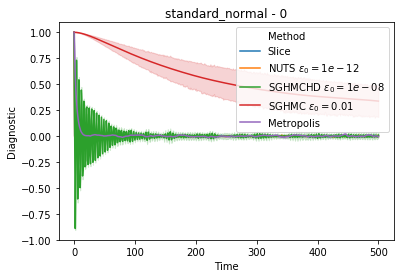

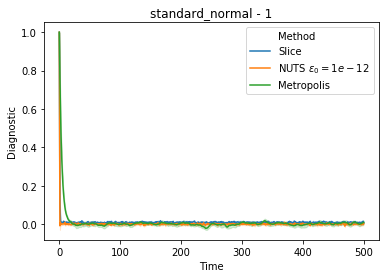

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join as path_join
import seaborn as sns

def get_hdf_store(diagnostic_name):
    hdf_filepath = path_join("/home/moritz/test_results", 
                             "{diagnostic}.hdf".format(
                                 diagnostic=diagnostic_name
                             ))
    print(hdf_filepath)
    return pd.HDFStore(hdf_filepath)

store = get_hdf_store("autocorrelation")
energy_functions = (
    "gmm1", "gmm2", "gmm3", "mogl2hmc",  # 1d
    "banana", "donut", "squiggle", "standard_normal",  #2d
)

def format_stepsize(stepsize):
    # XXX: Implement
    return stepsize
    
def rename(name):
    if (isinstance(name, tuple) and 
        name[0] in ("Metropolis", "Slice")):
        return name[0].title()
    
    elif isinstance(name, tuple):
        return "{} $\epsilon_0={}$".format(
            name[0], format_stepsize(name[1])
        )
    else:
        raise NotImplementedError()


def plot_autocorrelation(energy_function, 
                         only_methods=None, 
                         max_lag=10**4,
                         output_folder=None):
    data = store[energy_function]
    data = data[data["Time"] <= max_lag]
    
    if callable(only_methods):
        data_ = data[data["Method"].apply(only_methods)]
    elif hasattr(only_methods, "__iter__"):
        data_ = data[data["Method"].apply(lambda x: x in only_methods)]
    else:
        data_ = data
    parameter_names = sorted(data["Parameter Name"].unique())
    
    new_method_names = data_["Method"].apply(rename)
    data_.loc[:, "Method"] = new_method_names
    for parameter_name in parameter_names:
        ax = sns.lineplot(
            x="Time",
            y="Diagnostic",
            hue="Method",
            data=data_[data_["Parameter Name"] == parameter_name],
            markers=True, dashes=False
        )
        ax.set_title("{} - {}".format(energy_function, parameter_name))
        if output_folder is not None:
            output_filename = path_join(
                output_folder, "{}_{}.pdf".format(
                    energy_function, parameter_name
            ))
            plt.savefig(output_filename, format="pdf")
        plt.show()

## Autocorrelation


METHODS = (
    ("Metropolis", None),
    ("Slice", None),
    ("SGHMC", 0.01),
    ("SGHMCHD", 1e-8),
    ("NUTS", 1e-12),
)
max_lag = 500

for energy_function in energy_functions:
    plot_autocorrelation(energy_function, 
                         only_methods=METHODS,
                         max_lag=max_lag)
    



## Tables

We generate tables for autocorrelation within first $n$ steps of sampling and effective sample size (ESS) per iteration/gradient computation. 


### Autocorrelation

In [6]:
from tqdm import tqdm
import sys
sys.path.insert(0, "../../../")
from pysgmcmc_experiments.table_utils import TABLES_DIRECTORY, latex_table
from pysgmcmc_experiments.utils import format_sampler

energy_functions = (
    "gmm1", "gmm2", "gmm3", "mogl2hmc",  # 1d
    "banana", "donut", "squiggle",  #2d
)

    
def rename(name):
    if (isinstance(name, tuple) and 
        name[0] in ("Metropolis", "Slice")):
        return name[0].title()
    
    elif isinstance(name, tuple):
        return "{} $\epsilon_0={}$".format(
            name[0], format_stepsize(name[1])
        )
    
    titlecase_these = (
        "gmm1", "gmm2", "gmm3", "banana", "donut", "squiggle"
    )
    if name in titlecase_these:
        return name.title()
    mappings = {
        "mogl2hmc": "MoGL2HMC",
        "standard_normal": "Standard Normal"
    }
    return mappings[name]


def autocorrelation_table(only_methods=None, max_lag=10 ** 4, ):
    from collections import defaultdict
    records = defaultdict(dict)
    for energy_function in tqdm(energy_functions, total=len(energy_functions)):
        data = store[energy_function]
        data = data[data["Time"] <= max_lag]
        
        if callable(only_methods):
            data_ = data[data["Method"].apply(only_methods)]
        elif hasattr(only_methods, "__iter__"):
            data_ = data[data["Method"].apply(lambda x: x in only_methods)]
        else:
            data_ = data
            
        data_["Diagnostic"] = data_["Diagnostic"].abs()
        
        for method in sorted(data_["Method"].unique()):
            data_method = data_[data_["Method"] == method]
            parameter_max = data_method.loc[data_method.groupby(["Chain Number", "Time"])["Diagnostic"].idxmax(),]
            median_val = parameter_max["Diagnostic"].median()
            
            function_name = rename(energy_function)
            records[function_name][format_sampler(*method)] = "{:.2f}".format(median_val)
            

    df = pd.DataFrame.from_records(records)
    df2 = df.astype(float)
    winners_index = df2.idxmin(axis=0)
    for function, method in winners_index.items():
        winning_value = df2[function][method]
        df[function][method] = "\mathbf{{{}}}".format(winning_value)

    df = df.applymap(lambda x: "${}$".format(x))
    df = df.rename(columns={column: "\rotatebox{{45}}{{{name}}}".format(name=column) for column in df.columns.values})
    return latex_table(
        inner_tabular=df.to_latex(escape=False),
        caption="CAPTION",
        label="autocorrelation",
        # XXX: Also name methods and lag?
        output_filepath=path_join(
            TABLES_DIRECTORY, 
            "energy_functions",
            "autocorrelation"
        )
    )
        
    
autocorrelation_table(max_lag=3000)


100%|██████████| 7/7 [08:08<00:00, 69.85s/it]


'\\begin{table}[H]%\n\\begin{tabular}{llllllll}\n\\toprule\n{} & \\rotatebox{45}{Banana} & \\rotatebox{45}{Donut} & \\rotatebox{45}{Gmm1} & \\rotatebox{45}{Gmm2} & \\rotatebox{45}{Gmm3} & \\rotatebox{45}{MoGL2HMC} & \\rotatebox{45}{Squiggle} \\\\\n\\midrule\nMetropolis                      &                 $0.27$ &                $0.13$ &      $\\mathbf{0.01}$ &      $\\mathbf{0.01}$ &      $\\mathbf{0.01}$ &                   $0.51$ &          $\\mathbf{0.02}$ \\\\\nNUTS $\\epsilon_0 = 10^{-10}$    &                 $0.42$ &       $\\mathbf{0.01}$ &               $0.04$ &               $0.03$ &               $0.03$ &          $\\mathbf{0.01}$ &                   $0.03$ \\\\\nNUTS $\\epsilon_0 = 10^{-12}$    &                 $0.36$ &                $0.01$ &               $0.04$ &               $0.04$ &               $0.03$ &                   $0.76$ &                   $0.03$ \\\\\nNUTS $\\epsilon_0 = 10^{-1}$     &                 $0.48$ &                $0.01$ &               $0.03

### Effective Sample Size


In [ ]:
import pandas as pd
from os.path import join as path_join

import sys
sys.path.insert(0, "../../../")
from pysgmcmc_experiments.table_utils import latex_table, TABLES_DIRECTORY


def get_hdf_store():
    hdf_filepath = path_join("/home/moritz/test_results", 
                             "effective_sample_size.hdf")
    return pd.HDFStore(hdf_filepath)

store = get_hdf_store()
energy_functions = (
    "gmm1", "gmm2", "gmm3", "mogl2hmc",  # 1d
    "banana", "donut", "squiggle",  #2d
)


def effective_sample_size_table(only_methods=None):
    def format_result(x):
        if not x.startswith("$"):
            return x
        elif x.startswith("$") and x.startswith("$\\mathbf"):
            x_ = x[x.find("{") + 1: x.find("}")]
            return "${:.4f}$".format(float(x_.strip("$"))) 
        return "${:.4f}$".format(float(x.strip("$")))
    df = store["data"]
    df = df.applymap(format_result)

    return latex_table(
        inner_tabular=df.to_latex(escape=False),
        caption="CAPTIONSTEAL FROM L2HMC",
        label="effective-sample-size",
        # XXX: Include only certain methods and reflect that in outputfilename?
        output_filepath=path_join(
            TABLES_DIRECTORY,
            "energy_functions",
            "effective_sample_size"
        )
    )

only_methods = None
effective_sample_size_table(only_methods)